# Medicinal Image Plant Analysis - Dataset 2

#  Data Processing for a dataset that doesn't have a training and validation sub-folders defined using Inception model customization

We are going to use medicinal image dataset (https://data.mendeley.com/datasets/nnytj2v3n5/1) to illustrate the data processing and model preparation. Also, we are going to use  here a pre-trained inception(InceptionV3) model with custom layers on top of it for analysis & prediction of the medicinal plants data.

# All common imports

In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers
import os

# Generic function to return training and validation dataset

In [48]:
# grader-required-cell

#The below function takes in the folder path of the training and validation subfolders as arguments

# GRADED FUNCTION: train_val_generators
def train_val_generators(DATA_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     validation_split=0.2, #This defines that validation data should be 20% of the whole dataset
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=DATA_DIR,
                                                      batch_size=50,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      subset = 'training',
                                                      target_size=(224, 224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=DATA_DIR,
                                                                batch_size=50,
                                                                class_mode='categorical',
                                                                shuffle=False,
                                                                subset = 'validation',
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

In [49]:
#The images and classification folder doesn't have subfolders like training and validation andwe are going to split it in the
#train_val_generators method using ImageDatagenerator's property
DATA_DIR = "./tmp/medicinal-images-1/"
# Test your generators
train_generator, validation_generator = train_val_generators(DATA_DIR)

Found 1802 images belonging to 30 classes.
Found 435 images belonging to 30 classes.


# Building a model 

In [50]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  ### Using the inception model as base while creating layers on top of it
  local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

  pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

  # Load the pre-trained weights you downloaded.
  pre_trained_model.load_weights(local_weights_file)

  # Freeze the weights of the layers.
  for layer in pre_trained_model.layers:
     layer.trainable = False

  # Choose `mixed7` as the last layer of your base model
  last_layer = pre_trained_model.get_layer('mixed7')
  #print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.1)(x) #This is to minimize the model to overfit by randomly de-activating 10% of neurons
  x = layers.Dense(512, activation='relu')(x)
  # Add a dropout rate of 0.4
  x = layers.Dropout(0.4)(x)                  
  # Add a final sigmoid layer for classification
  x = layers.Dense  (30, activation='softmax')(x)    
    
  model = Model(pre_trained_model.input, x) 
  
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  ### END CODE HERE

  return model

# Train the model

In [51]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/20
37/37 [==============================] - 124s 3s/step - loss: 6.1051 - accuracy: 0.1709 - val_loss: 2.3004 - val_accuracy: 0.3425
Epoch 2/20
37/37 [==============================] - 112s 3s/step - loss: 2.3706 - accuracy: 0.3230 - val_loss: 1.4226 - val_accuracy: 0.5747
Epoch 3/20
37/37 [==============================] - 111s 3s/step - loss: 1.7199 - accuracy: 0.4650 - val_loss: 0.7802 - val_accuracy: 0.7540
Epoch 4/20
37/37 [==============================] - 113s 3s/step - loss: 1.1755 - accuracy: 0.6154 - val_loss: 0.5789 - val_accuracy: 0.8161
Epoch 5/20
37/37 [==============================] - 112s 3s/step - loss: 1.0243 - accuracy: 0.6604 - val_loss: 0.5019 - val_accuracy: 0.8299
Epoch 6/20
37/37 [==============================] - 111s 3s/step - loss: 0.7327 - accuracy: 0.7564 - val_loss: 0.3644 - val_accuracy: 0.8874
Epoch 7/20
37/37 [==============================] - 111s 3s/step - loss: 0.5719 - accuracy: 0.8124 - val_loss: 0.6878 - val_accuracy: 0.8115
Epoch 8/20
37

# Plot the accuracy

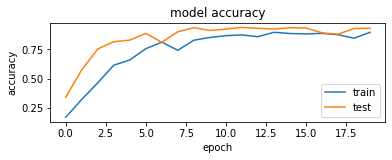

In [52]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

# Plot the loss


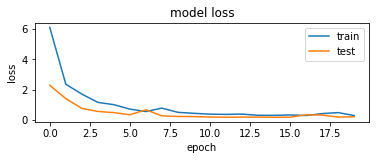

In [53]:
plot.subplot(2,1,2)
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

In [54]:
medicinal_leaf_labels = os.listdir("./tmp/medicinal-images-1")
print(medicinal_leaf_labels)

['Alpinia Galanga (Rasna)', 'Amaranthus Viridis (Arive-Dantu)', 'Artocarpus Heterophyllus (Jackfruit)', 'Azadirachta Indica (Neem)', 'Basella Alba (Basale)', 'Brassica Juncea (Indian Mustard)', 'Carissa Carandas (Karanda)', 'Citrus Limon (Lemon)', 'Ficus Auriculata (Roxburgh fig)', 'Ficus Religiosa (Peepal Tree)', 'Hibiscus Rosa-sinensis', 'Jasminum (Jasmine)', 'Mangifera Indica (Mango)', 'Mentha (Mint)', 'Moringa Oleifera (Drumstick)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Murraya Koenigii (Curry)', 'Nerium Oleander (Oleander)', 'Nyctanthes Arbor-tristis (Parijata)', 'Ocimum Tenuiflorum (Tulsi)', 'Piper Betle (Betel)', 'Plectranthus Amboinicus (Mexican Mint)', 'Pongamia Pinnata (Indian Beech)', 'Psidium Guajava (Guava)', 'Punica Granatum (Pomegranate)', 'Santalum Album (Sandalwood)', 'Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Trigonella Foenum-graecum (Fenugreek)']


# Make predictions using above model

1/1 [==============================] - 0s 90ms/step


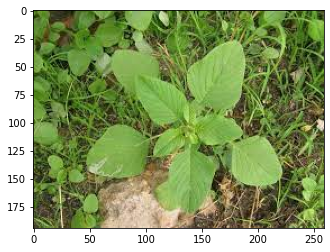

Medicinal Plant is Amaranthus Viridis (Arive-Dantu)


In [61]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

fn="av1.jpg"
image_path='./sample_dir_creation/' + fn

image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
x=img_to_array(image)
x /= 255.0
x=np.expand_dims(x, axis=0)
classes = model.predict(x)

img = mpimg.imread(image_path)
plt.imshow(img)

plt.show()

category=np.array(classes[0]).argmax()
print("Medicinal Plant is " + medicinal_leaf_labels[category])
